This notebook is used for training an LSTM model to predict the Remaining Useful Life (RUL) of turbofan engines based on simulated sensor data.

## Library

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Set for reproducability
np.random.seed(101)  
PYTHONHASHSEED = 0

import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, GRU, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, TimeDistributed, Masking, Activation, RepeatVector

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score

import sys
sys.path.insert(0,'../')

from data_generator import TSDataGenerator, split_data, create_generators
from util import set_log_dir, rmse
from util import LRDecay

from tqdm import tqdm, tqdm_notebook
from model import *

In [2]:
DATA_DIR = os.path.abspath("../dataset/")
MODEL_DIR = os.path.abspath("../model/")

persist_run_stats = True # Enable for saving results to CouchDB

In [ ]:
MODEL_DIR

### Load Data

The data used for this project is the NASA C-MAPSS Turbofan Engine Degradation Data Set https://ti.arc.nasa.gov/c/6/.  This data is model based simulated data from the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS).

In [3]:
!ls {DATA_DIR}

Damage Propagation Modeling.pdf test_FD002.txt
RUL_FD001.txt                   test_FD003.txt
RUL_FD002.txt                   test_FD004.txt
RUL_FD003.txt                   train_FD001.txt
RUL_FD004.txt                   train_FD002.txt
readme.txt                      train_FD003.txt
test_FD001.txt                  train_FD004.txt


The data set is a multivariate time series. Each entry (row) reflects an operational cycle of a specific engine identified by engine id and cycle time. There are multiple entries per engine to represent different reporting times. Other columns represents different features 3 operational settings and 21 sensors:

<pre>
    1)      engine id
    2)      time, in cycles
    3)      operational setting 1
    4)      operational setting 2
    5)      operational setting 3
    6)      sensor measurement  1
    7)      sensor measurement  2
    ...
    26)     sensor measurement  21
</pre>

In [4]:
cols = ['id', 'cycle' ]

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
cols.extend(sensor_cols)

sort_cols = ['id','cycle']


The CMAPSS data is divided into training, test, and RUL data files. Each of these is further partitioned in 4 subsets that represents a different operational condition. The number of engines in each vary.

In [5]:

fn_id_map = {
    "train_FD001": 1000,
    "train_FD002": 2000,
    "train_FD003": 3000,
    "train_FD004": 4000,
    "test_FD001":  5000,
    "test_FD002":  6000,
    "test_FD003":  7000,
    "test_FD004":  8000,    
    "RUL_FD001":  5000,
    "RUL_FD002":  6000,
    "RUL_FD003":  7000,
    "RUL_FD004":  8000, 
}


# Filename is mapped to a condition. Map:
#       ONE (Sea Level) to 0
#       SIX to 1
fn_condition_map = {
    "train_FD001": 1,
    "train_FD002": 2,
    "train_FD003": 1,
    "train_FD004": 2,
    "test_FD001":  1,
    "test_FD002":  2,
    "test_FD003":  1,
    "test_FD004":  2,    
}

In [6]:

def load_data(paths, col_names, sort_cols):
    # read data 
    df = pd.DataFrame()
    for p in paths:
        instance_df = pd.read_csv(p, sep=" ", header=None)
        instance_df.drop(instance_df.columns[[26, 27]], axis=1, inplace=True)
        instance_df.columns = col_names
        instance_df['filename'] = os.path.splitext(os.path.basename(p))[0]
        
        df = pd.concat((df, instance_df), sort=False) 

    df['condition'] = df['filename'].apply( lambda f: fn_condition_map[f])
    df['id'] = df['id'] + df['filename'].apply( lambda f: fn_id_map[f])
    df.drop(['filename'], axis=1, inplace=True)
    df = df.sort_values(sort_cols)
    return df

Read training, validation, and test data 


In [7]:
path = os.path.join(DATA_DIR, "train_FD*.txt")
all_files = glob.glob(path)

train_df = load_data(all_files, cols, sort_cols)
print("Train: ", train_df.shape)


Train:  (160359, 27)


In [8]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,condition
0,1001,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1
1,1001,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1
2,1001,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1
3,1001,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1
4,1001,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1


In [9]:
train_df.tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,condition
61244,4249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,2388.73,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234,2
61245,4249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,2388.46,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151,2
61246,4249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,2388.48,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270,2
61247,4249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,2388.83,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774,2
61248,4249,255,42.0030,0.8400,100.0,445.00,549.85,1369.75,1147.45,3.91,...,2388.66,8144.33,9.1207,0.02,333,2212,100.0,10.66,6.4341,2


---
## Data Preparation

Two step process. First step is to calculate the Remaining Useful Life (RUL) that will be used as the label. The calculation different when using training or test files. Second, the data will be transformed using a min/max scaler.

### Calculate Training Data RUL

In [10]:
def calc_training_rul(df):
    # Data Labeling - generate column RUL
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop('max', axis=1, inplace=True)
    return df

In [11]:
train_df = calc_training_rul(train_df)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,condition,RUL
0,1001,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1,191
1,1001,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1,190
2,1001,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1,189
3,1001,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1,188
4,1001,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1,187


In [12]:
train_df.tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,condition,RUL
160354,4249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234,2,4
160355,4249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151,2,3
160356,4249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270,2,2
160357,4249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774,2,1
160358,4249,255,42.0030,0.8400,100.0,445.00,549.85,1369.75,1147.45,3.91,...,8144.33,9.1207,0.02,333,2212,100.0,10.66,6.4341,2,0



### Data Transform

All transforms will be done using a pipeline. At this time only the min_max scalar is used.

In [13]:
pipeline = Pipeline(steps=[
    # The default activation function for LSTM tanh, so we'll use a range of [-1,1].
    ('min_max_scaler', preprocessing.MinMaxScaler(feature_range=(-1, 1)))
])

Transform training data.

In [14]:
# Set up the columns that will be scaled
train_df['cycle_norm'] = train_df['cycle']

# Transform all columns except id, cycle, and RUL
cols_transform = train_df.columns.difference(['id','cycle', 'RUL'])

xform_train_df = pd.DataFrame(pipeline.fit_transform(train_df[cols_transform]), 
                             columns=cols_transform, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_transform)].join(xform_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,condition,RUL,cycle_norm
0,1001,1,-0.999619,-0.999525,1.0,1.0,0.939980,0.854585,0.804223,1.0,...,-0.819144,1.0,0.836735,1.0,1.0,0.944164,0.940747,-1.0,191,-1.00000
1,1001,2,-0.999495,-0.999288,1.0,1.0,0.946000,0.865915,0.816384,1.0,...,-0.810692,1.0,0.836735,1.0,1.0,0.940128,0.941260,-1.0,190,-0.99631
2,1001,3,-0.999791,-0.997864,1.0,1.0,0.949649,0.845447,0.821459,1.0,...,-0.820312,1.0,0.795918,1.0,1.0,0.936764,0.932408,-1.0,189,-0.99262
3,1001,4,-0.999553,-0.998576,1.0,1.0,0.949649,0.817657,0.810304,1.0,...,-0.854394,1.0,0.836735,1.0,1.0,0.932055,0.935719,-1.0,188,-0.98893
4,1001,5,-0.999676,-0.999051,1.0,1.0,0.950014,0.817978,0.831131,1.0,...,-0.812341,1.0,0.857143,1.0,1.0,0.933401,0.939119,-1.0,187,-0.98524


In [15]:
train_df.tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,condition,RUL,cycle_norm
160354,4249,251,-0.523594,-0.405174,1.0,0.195873,0.274286,0.462644,0.395720,0.234360,...,-0.795369,1.0,0.428571,0.708245,1.0,0.274807,0.283489,1.0,4,-0.077491
160355,4249,252,-0.999453,-0.995015,1.0,1.000000,0.969169,0.903858,0.929522,1.000000,...,-0.954786,1.0,0.918367,1.000000,1.0,0.965691,0.973757,1.0,3,-0.073801
160356,4249,253,-0.999448,-0.998576,1.0,1.000000,0.973912,0.950887,0.947668,1.000000,...,-0.933897,1.0,0.897959,1.000000,1.0,0.992600,0.986232,1.0,2,-0.070111
160357,4249,254,0.666637,0.995253,1.0,-0.879462,-0.629846,-0.259192,-0.404338,-0.706816,...,-0.384869,-1.0,-0.285714,0.302326,1.0,-0.656912,-0.658094,1.0,1,-0.066421
160358,4249,255,0.999762,0.995253,1.0,-1.000000,-0.737845,-0.320864,-0.407833,-1.000000,...,-0.337319,-1.0,-0.367347,0.255814,1.0,-0.966364,-0.952776,1.0,0,-0.062731


---
## Model

Identify the columns that will be used for features and labels.

In [16]:
# Build the feature column list 
feature_cols = ['cycle_norm', 'condition']

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
feature_cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
feature_cols.extend(sensor_cols)

# Build the label column list
label_cols = ['RUL']

In [17]:
feature_cols, len(feature_cols), len(label_cols)

(['cycle_norm',
  'condition',
  'setting1',
  'setting2',
  'setting3',
  's1',
  's2',
  's3',
  's4',
  's5',
  's6',
  's7',
  's8',
  's9',
  's10',
  's11',
  's12',
  's13',
  's14',
  's15',
  's16',
  's17',
  's18',
  's19',
  's20',
  's21'],
 26,
 1)

CNN-GRU Network


An Adam optimizer is used and Root Mean Squared Error (RMSE) is used for the loss function:

\begin{equation}
    RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (\hat{y}^i-RUL^i)^2 }
\end{equation}

Mean Squared Error (MSE) and Mean Absolute Error (MAE) are also tracked as metrics.


In [19]:
import keras.backend as K
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
"""
def create_model(batch_size, seq_length, num_features, num_labels):
    # build the network

    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=5, strides=1 , activation='relu', padding='causal', 
                     input_shape=(sequence_length, num_features), 
                     batch_input_shape=(batch_size, sequence_length, num_features)))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
    model.add(Dropout(0.05))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1 , activation='relu', padding='causal'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
    model.add(Dropout(0.05))
    #model.add(Conv1D(filters=32, kernel_size=3, strides=1 , activation='relu', padding='causal'))
    #model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
    #model.add(Dropout(0.05))
    model.add(GRU(
             units=256,
             stateful=True,
             dropout=0.05,
             return_sequences=True))
    model.add(GRU(
             units=128,
             dropout=0.05,
             return_sequences=True,
             stateful=True))
    #model.add(GRU(
    #         units=64,
    #         dropout=0.05,
    #         return_sequences=True,
    #         stateful=True))

    model.add(GRU(
             units=64,
             dropout=0.05))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=num_labels, activation='relu'))
    
    return model
"""

'\ndef create_model(batch_size, seq_length, num_features, num_labels):\n    # build the network\n\n    model = Sequential()\n\n    model.add(Conv1D(filters=128, kernel_size=5, strides=1 , activation=\'relu\', padding=\'causal\', \n                     input_shape=(sequence_length, num_features), \n                     batch_input_shape=(batch_size, sequence_length, num_features)))\n    model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))\n    model.add(Dropout(0.05))\n    model.add(Conv1D(filters=64, kernel_size=3, strides=1 , activation=\'relu\', padding=\'causal\'))\n    model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))\n    model.add(Dropout(0.05))\n    #model.add(Conv1D(filters=32, kernel_size=3, strides=1 , activation=\'relu\', padding=\'causal\'))\n    #model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))\n    #model.add(Dropout(0.05))\n    model.add(GRU(\n             units=256,\n             stateful=True,\n             dropout=0.05,\n    

In [23]:
# Size of the series time window.
sequence_length = 25

# Number of time series sequences that will be train on per batch.
batch_size = 512

num_features = len(feature_cols)
num_labels = len(label_cols)

num_gru = 3

# Create the model
model = model_gru(num_gru, sequence_length, num_features, num_labels)

model.compile(loss=rmse, optimizer='rmsprop',metrics=['mse',r2_keras])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_129 (GRU)               (None, 25, 256)           218112    
                                                                 
 gru_130 (GRU)               (None, 25, 128)           148224    
                                                                 
 gru_131 (GRU)               (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 409857 (1.56 MB)
Trainable params: 40985

---
## Train

In [ ]:
# Setup log directory
log_dir, checkpoint_path = set_log_dir(MODEL_DIR, "engine")

print("Log dir: ", log_dir)
print("Checkpoint path: ", checkpoint_path)

# Save the pipeline for later use
import joblib 
pipeline_path = os.path.join(log_dir, 'engine_pipeline.pkl') 
joblib.dump(pipeline, pipeline_path) 

In [28]:
training_runs = 4
num_epochs = 5
initial_epoch = 0
epochs_before_decay = 15
lrate = 1e-3
patience = 10
    
tensorboard = TensorBoard(log_dir=log_dir,
                        histogram_freq=0, write_graph=True, write_images=False)

checkpointer = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True)

epoch_loss_history = []
epoch_val_history = []
epoch_lr_history = []

start = time.time()
for tr_run in range(training_runs):

    print("Training run: {}, epoch: {}".format(tr_run, initial_epoch))

    t_df, v_df = split_data(train_df, randomize=True, train_pct=.8)
    train_data_generator, val_data_generator = create_generators(t_df, v_df, 
                                                                 feature_cols, 
                                                                 label_cols, 
                                                                 batch_size=batch_size, 
                                                                 sequence_length=sequence_length, 
                                                                 randomize=True, 
                                                                 loop=True,
                                                                 pad=False,
                                                                 verbose=True)
       
    # Callbacks
    lr_decay = LRDecay(initial_lrate=lrate, epochs_step=epochs_before_decay)
    lr_scheduler = LearningRateScheduler(lr_decay.step_decay, verbose=1)
    
    earlystopper = EarlyStopping(patience=patience, verbose=1)
    
    callbacks = [ tensorboard, checkpointer, lr_scheduler, earlystopper]

    # fit the network
    history = model.fit(
        train_data_generator.generate(), 
        validation_data=val_data_generator.generate(), 
        initial_epoch=initial_epoch,
        epochs=num_epochs, 
        steps_per_epoch=train_data_generator.summary()['max_iterations'],
        validation_steps=val_data_generator.summary()['max_iterations'],
        shuffle=False,
        verbose=1,
        callbacks=callbacks )
    
    # pick up after the last epoch
    if len(history.epoch) > 0:        
        initial_epoch = history.epoch[-1] + 1
    
    # TODO fix, sometimes Keras is returning an empty history dict.
    try:
        # Save loss/val metrics
        epoch_loss_history += history.history['loss']
        epoch_val_history += history.history['val_loss']
        epoch_lr_history += lr_decay.history_lr
    except:
        pass
    
    # reduce starting lr as we iterate into another training loop
    #lrate /= 10
    
    print("Loading previous best weights: ", checkpoint_path)
    model.load_weights(checkpoint_path)
print("Total time: ", time.time() - start, "seconds")

Training run: 0, epoch: 0
Engine split: Training=0.80, Validation=0.20
Cycle split:  Training=0.80, Validation=0.20
Number of items:  567
Undersized items:  0
Data shape:  (128872, 29)
Max steps:  115264
Max iterations: 225 @ 512
Number of items:  142
Undersized items:  0
Data shape:  (31487, 29)
Max steps:  28079
Max iterations: 54 @ 512

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5
225/225 [==============================] - ETA: 0s - loss: 78.2516 - mse: 7039.4224 - r2_keras: -0.2313
Epoch 00001: val_loss improved from inf to 70.89720, saving model to c:\Users\khali\Documents\PROJEKAN\Projekan 6\RUL_prediction\model\engine20220331T2125\engine_model.h5
225/225 [==============================] - 347s 2s/step - loss: 78.2516 - mse: 7039.4224 - r2_keras: -0.2313 - val_loss: 70.8972 - val_mse: 5630.4966 - val_r2_keras: -0.0734 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
225/225 [==============================] 

KeyboardInterrupt: 

:Plot the training and validation loss across all runs overlayed with the learning rate used.

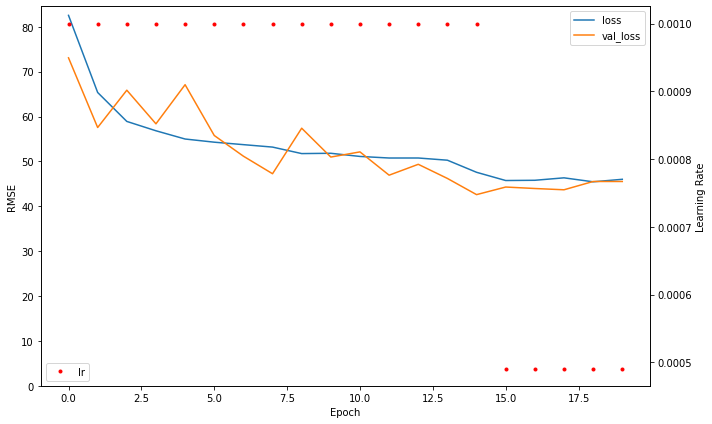

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

epochs = np.arange(len(epoch_loss_history))
ax1.plot(epochs, epoch_loss_history, label='loss')
ax1.plot(epochs, epoch_val_history, label='val_loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("RMSE")
ax1.set_ylim(0)
ax1.legend()

# Add a rhs scale for the LR.
ax2 = ax1.twinx()
lr_epochs = []
lr_steps = []

for e1, l1, l2 in epoch_lr_history:
    lr_epochs.append(e1)
    lr_steps.append(l1)


ax2.plot(lr_epochs, lr_steps, 'r.', label='lr')
ax2.set_ylabel("Learning Rate")
ax2.legend(loc='lower left')

fig.tight_layout()
plt.show()

---
## Test

Loading and pre-processing the test data is similar to how validation data was handled.


#### Load Model

Reload the latest, best model from this run.

In [ ]:
print("Loading model: ", checkpoint_path)
custom_objects={'rmse':rmse, 'r2_keras':r2_keras}
inf_model = load_model(checkpoint_path, custom_objects=custom_objects)

inf_model.summary()

Loading model:  /content/drive/MyDrive/PROJEK_GRU/model/engine20220323T1417/engine_model.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (512, 25, 128)            16768     
                                                                 
 max_pooling1d (MaxPooling1D  (512, 24, 128)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (512, 24, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (512, 24, 64)             24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (512, 23, 64)            0         
 1D)                                                             
                              

#### Load prepare test data

Calculating RUL for test data is a bit more involved. For evaluation we'll be using the data from the test_FD003.txt files and the corresponding RUL_FD003.txt for the actual RUL ground truth. This allows us to utilize more data for training. The key calculation difference is that the last cycle in the these files must equal the ground truth RUL. Therefore we compute the RUL for each entry by working backwards from the last cycle entry.

In [ ]:
dataset_name = 'FD002'

test_X_path = os.path.join(DATA_DIR, 'test_' + dataset_name + '.txt')
test_y_path = os.path.join(DATA_DIR, 'RUL_' + dataset_name + '.txt')

In [ ]:

def load_rul_data(paths, col_names):
    
    # Filename is used to determine the condition
    col_names.append('filename')

    # read data 
    df = pd.DataFrame()
    for p in paths:
        instance_df = pd.read_csv(p, sep=" ", header=None)
        instance_df.drop(instance_df.columns[[1]], axis=1, inplace=True)
        instance_df['filename'] = os.path.splitext(os.path.basename(p))[0]
        instance_df = instance_df.reset_index()
        instance_df.columns = col_names
        
        df = pd.concat((df, instance_df), sort=False) 

    df['id'] = df['id'] + df['filename'].apply( lambda f: fn_id_map[f]) + 1
    df.drop(['filename'], axis=1, inplace=True)
    return df



In [ ]:
def calc_test_rul( feature_df, label_df):
    # If index is not reset there will be int/str type issues when attempting the merge. 
    cycle_count_df = feature_df.groupby('id').count().reset_index()[['id','cycle']].rename(index=str, columns={"cycle":"cycles"}).reset_index(drop=True)
    print(cycle_count_df.shape)

    # Join cycle and RUL dataframes
    assert cycle_count_df.shape[0] == label_df.shape[0]
    tmp_df = cycle_count_df.merge(label_df, on="id", how='left')

    # The RUL actual column contains the value for the last cycle.
    # Adding the cycles column will give us the RUL for the first cycle.
    tmp_df['RUL_actual'] = tmp_df['cycles'] + tmp_df['RUL_actual']
    tmp_df.drop('cycles',  axis=1, inplace=True)

    # Join the two data frames
    feature_df = feature_df.merge(tmp_df, on='id', how='left')


    # Use the cycle to decrement the RUL until the ground truth is reached.
    feature_df['RUL'] = feature_df['RUL_actual'] - feature_df['cycle']
    feature_df.drop('RUL_actual',  axis=1, inplace=True)
    
    return feature_df


In [ ]:
# Read in the features
test_df = load_data([test_X_path], cols, sort_cols)

# Read in the labels (RUL)
test_rul_df = load_rul_data([test_y_path], ['id', 'RUL_actual'])

# Calculate the RUL and merge back to the test dataframe
test_df = calc_test_rul(test_df, test_rul_df)
test_df.head()


(259, 2)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,condition,RUL
0,6001,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,2,275
1,6001,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,2,274
2,6001,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,2,273
3,6001,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,2,272
4,6001,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,2,271


Transform test data

In [ ]:

test_df['cycle_norm'] = test_df['cycle']

norm_test_df = pd.DataFrame(pipeline.transform(test_df[cols_transform]), 
                            columns=cols_transform, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_transform)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [ ]:
test_df.head()[feature_cols]

,cycle_norm,condition,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,-1.00000,1.0,-0.523647,-0.404700,1.0,0.195873,0.268813,0.360090,0.346452,0.234360,...,0.189599,0.987270,0.198018,-0.662406,1.0,0.367347,0.708245,1.0,0.228389,0.242430
1,-0.99631,1.0,-0.047460,0.662948,1.0,0.253970,0.319712,0.274743,0.064541,0.015873,...,-0.085928,0.986939,-0.074519,-0.254999,-1.0,0.265306,0.729387,1.0,-0.049445,-0.019688
2,-0.99262,1.0,0.666633,0.995253,1.0,-0.879462,-0.625650,-0.377886,-0.499234,-0.706816,...,-0.732489,0.984900,-0.074608,-0.181681,-1.0,-0.367347,0.302326,1.0,-0.675748,-0.676477
3,-0.98893,1.0,0.999933,0.997626,1.0,-1.000000,-0.732008,-0.428068,-0.501484,-1.000000,...,-0.989784,0.984735,-0.012725,-0.148079,-1.0,-0.387755,0.255814,1.0,-0.987218,-0.954560
4,-0.98524,1.0,0.190346,0.476145,-1.0,-0.523822,-0.977378,-0.943833,-0.871110,-0.413632,...,-0.822816,-0.997355,-0.911238,0.863465,-1.0,-0.938776,-1.000000,-1.0,-0.720821,-0.714214


In [ ]:
test_df.head()[label_cols]

,RUL
0,275
1,274
2,273
3,272
4,271


#### Evaluate

Collect metrics across then entire test sample.

In [ ]:
test_data_generator = TSDataGenerator(test_df, 
                                      feature_cols, 
                                      label_cols,
                                      batch_size=batch_size,
                                      seq_length=sequence_length, 
                                      randomize=False,
                                      loop=False)
test_data_generator.print_summary()

X = []
y = []
for p in tqdm_notebook(test_data_generator.generate(), total=test_data_generator.summary()['max_iterations']):
    X.append(p[0])
    y.append(p[1])

test_X = np.vstack(X)
test_y = np.vstack(y)


Number of items:  256
Undersized items:  3
Data shape:  (33991, 29)
Max steps:  27781
Max iterations: 54 @ 512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
# Evaluation metrics are RMSE, MSE, MAE
score = inf_model.evaluate(test_X, test_y, verbose=1, batch_size=batch_size)
print('Test score:\n\tRMSE: {}\n\tMSE: {}\n\tR2: {}'.format(*score))

54/54 [==============================] - 1s 11ms/step - loss: 41.5914 - mse: 1875.0376 - r2_keras: 0.4146
Test score:
	RMSE: 41.59138488769531
	MSE: 1875.03759765625
	R2: 0.4146037697792053


Predict on one batch from the test data. This is a fragment of the data.

In [ ]:
test_data_generator = TSDataGenerator(test_df, feature_cols, label_cols, batch_size=batch_size, seq_length=sequence_length, loop=False)

g = test_data_generator.generate()
test_X, test_y = next(g)
y_pred_array = inf_model.predict_on_batch(test_X)

In [ ]:
def plot_prediction(rul_actual, rul_predicted):  
    fig = plt.figure(figsize=(25,5))
    cycles = np.arange(len(rul_actual))
    plt.scatter(cycles, rul_predicted, marker='.', label="Predicted")
    plt.plot(cycles, rul_actual, 'r', label="Actual")
    plt.xlabel("Cycle")
    plt.xlim(0)
    plt.ylabel("RUL")
    plt.ylim(0)

    plt.legend()
    plt.show()

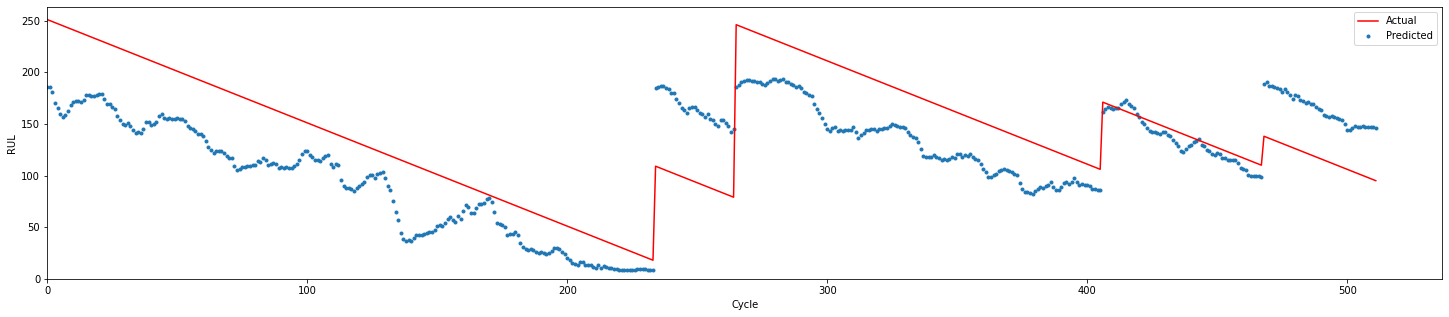

In [ ]:
plot_prediction(test_y, y_pred_array)

The above plot shows the first batch. As the sequence approaches the last time series entry, the prediction converged closeer to the actual RUL. Running a second batch gives us:

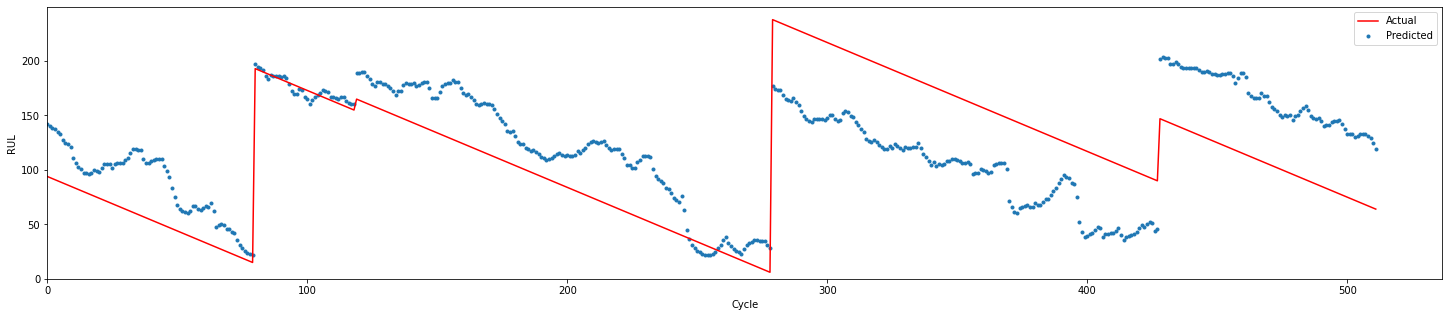

In [ ]:
test_X, test_y = next(g)
y_pred_array = inf_model.predict_on_batch(test_X)
plot_prediction(test_y, y_pred_array)

In [ ]:
# Evaluation metrics are RMSE, MSE, MAE
score = inf_model.evaluate(test_X, test_y, verbose=1, batch_size=batch_size)
print('Test score:\n\tRMSE: {}\n\tMSE: {}\n\tR2: {}'.format(*score))

1/1 [==============================] - 0s 27ms/step - loss: 48.6010 - mse: 2362.0537 - r2_keras: 0.2653
Test score:
	RMSE: 48.6009635925293
	MSE: 2362.0537109375
	R2: 0.26526087522506714
